In [197]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap


from collections import OrderedDict
from itertools import combinations
import matplotlib.pyplot as plt
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import pickle
import os

import seaborn as sns

In [2]:
with open("../variable_parameters.pickle", "rb") as f:
    variable_params = pickle.load(f)

In [3]:
problem = {
    'num_vars': 3,
    'names': ['forager_royal_ratio', 'growth_factor', "resource_variability"],
    'bounds': [[0.0, 1.0], [0.0, 1.0], [0.0, 0.5]]
}

In [4]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

data_9.pickle
data_7.pickle
data_1.pickle
data_4.pickle
data_6.pickle
data_0.pickle
                            ST   ST_conf
forager_royal_ratio   0.394802  0.028373
growth_factor         0.577307  0.036705
resource_variability  0.620560  0.032665
                            S1   S1_conf
forager_royal_ratio   0.180829  0.034094
growth_factor         0.217564  0.043247
resource_variability  0.367686  0.041363


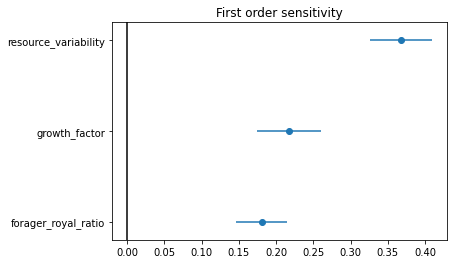

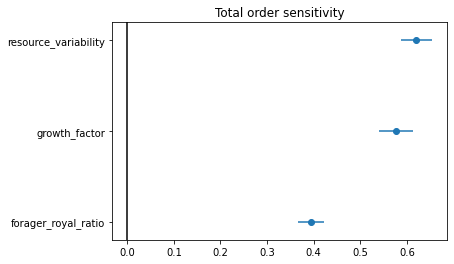

In [19]:
combined = OrderedDict()
for item in variable_params:
    key = (item["forager_royal_ratio"], item["growth_factor"], item["resource_variability"])
    combined[key] = []

for file in os.listdir():
    if "data_" in file and ".pickle" in file:
        with open(file, "rb") as f:
            data = pickle.load(f)
        print(file)
        for key, row in data.items():
            parameters = (key[0], key[1], key[2])
            if parameters in combined:
                combined[parameters].append(row)
            else:
                combined[parameters] = row

aggregated = {"forager_royal_ratio":[], "growth_factor":[], 
              "resource_variability":[], "Total Fertilized Queens":[]}

for key, rows in combined.items():
    for row in rows:
        aggregated["forager_royal_ratio"].append(key[0])
        aggregated["growth_factor"].append(key[1])
        aggregated["resource_variability"].append(key[2])
        aggregated["Total Fertilized Queens"].append(row["Total Fertilized Queens"][0])

final_dataframe = pd.DataFrame.from_dict(aggregated)

Si = sobol.analyze(problem, np.array(final_dataframe['Total Fertilized Queens']), 
                                     print_to_console=True, calc_second_order=False)

plot_index(Si, problem['names'], '1', 'First order sensitivity')
plt.show()
plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
plt.show()

# Results

In [ ]:
# for each unique param combination : take avg and stdev

# divide resource_var in 3 bins - rank strategies to find best in each category, best overall

In [35]:
avg_std = {}
for key, rows in combined.items():
    values = [rows[i]["Total Fertilized Queens"][0] for i in range(len(rows))]
    avg_std[key] = {"mean":np.mean(values), "std":np.std(values)}

In [36]:
avg_std[(0.0029296875, 0.2509765625, 0.47705078125)]

{'mean': 199.33333333333334, 'std': 86.88242374356021}

In [40]:
def find_best_strategy(min_resource_variability, max_resource_variability):
    
    best_val = -1
    best_strategy = None
    
    for key, item in avg_std.items():
        if min_resource_variability <= key[-1] <= max_resource_variability:
            if item["mean"] > best_val:
                best_strategy = key
                best_val = item["mean"]
                
    return best_strategy, best_val

In [126]:
for key in combined:
    if key[2] < 0.1:
        if  0.15 < key[1] <= 0.20:
            if key[0] <= 0.05:
                print(key)

In [50]:
grouped_by_stragegy = {}
for key, item in avg_std.items():
    strategy = (key[0], key[1])
    if strategy not in grouped_by_stragegy:
        grouped_by_stragegy[strategy] = {}
    for row in rows:
        grouped_by_stragegy[strategy][key[2]] = item["mean"]

In [138]:
bin_count = 10
bins = {(i,j):{} for i in range(bin_count) for j in range(bin_count)}

for key, stuff in grouped_by_stragegy.items():
    bin_location = (int(key[0]*bin_count), int(key[1]*bin_count))
    for resouce_var in stuff:
        if resouce_var not in bins[bin_location]:
            bins[bin_location][resouce_var] = []
        bins[bin_location][resouce_var].append(stuff[resouce_var])

In [139]:
bin_ranges = [(0.0, 0.1), (0.1, 0.4), (0.4, 0.5)]

performance = {r:[] for r in bin_ranges}

for b, dictionary in bins.items():
    p = {bin_ranges[0]:[], bin_ranges[1]:[], bin_ranges[2]:[]}
    for resource_var, performance_list in dictionary.items():
        if 0 < resource_var <= bin_ranges[0][1]:
            p[bin_ranges[0]] += performance_list
        elif bin_ranges[1][0] < resource_var <= bin_ranges[1][1]:
            p[bin_ranges[1]] += performance_list
        else:
            p[bin_ranges[2]] += performance_list
    for key in p:
        performance[key].append((b, np.mean(p[key])))

In [141]:
for k in performance:
    print(f"Resource Variability Range : {k}")
    temp =list(sorted(performance[k], key=lambda x:x[1], reverse=True))[:5]
    for item in temp:
        print(item)
    print()

Resource Variability Range : (0.0, 0.1)
((5, 9), 762.7916666666666)
((5, 8), 752.8055555555557)
((6, 9), 742.6333333333333)
((5, 7), 737.962962962963)
((6, 8), 736.7083333333334)

Resource Variability Range : (0.1, 0.4)
((6, 8), 732.8205128205128)
((6, 9), 732.0256410256409)
((5, 7), 731.5333333333334)
((5, 9), 728.5)
((5, 8), 728.375)

Resource Variability Range : (0.4, 0.5)
((4, 4), 690.6666666666666)
((7, 8), 687.2222222222222)
((6, 4), 681.6666666666666)
((6, 5), 673.8333333333333)
((5, 8), 671.8333333333334)



In [247]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#160c06', "#d09005", '#fbd604']
th = [0, 0.9, 1]

cdict = NonLinCdict(th, hc)
cm = LinearSegmentedColormap('test', cdict)

Resource Variability Range : (0.0, 0.1)


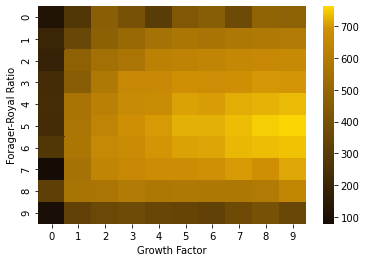

Resource Variability Range : (0.1, 0.4)


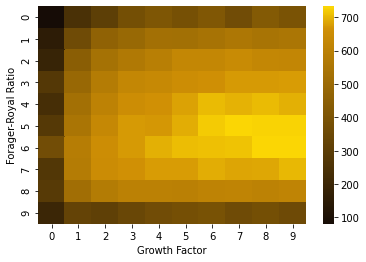

Resource Variability Range : (0.4, 0.5)


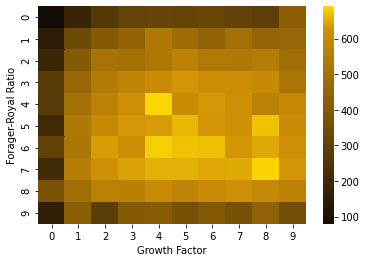

In [251]:
for key, stuff in performance.items():
    print(f"Resource Variability Range : {key}")
    rows = []
    for j in range(10):
        rows.append([x[1] for x in stuff[j*10:(j+1)*10]])        
    ax = sns.heatmap(np.array(np.vstack(rows)), cmap=cm)
    ax.set_xlabel("Growth Factor")
    ax.set_ylabel("Forager-Royal Ratio")
    plt.savefig(f'{key}.png')
    plt.show()